# Trajectory Optimization Experiments

This notebook provides comprehensive experiments for analyzing trajectory optimization methods across different parameters. The main focus is on understanding the relationship between:

1. **Number of samples** vs **Final cost performance**
2. **Convergence behavior** across different configurations
3. **Noise sampling strategies** impact on optimization

## Key Features:
- Configurable optimizers (MPPI, AVWBFO)
- Multiple noise schedulers (constant, exponential_decay, hierarchical)
- Different environments (navigation2d, inverted_pendulum)
- Multiple noise sampling strategies (MC, LHS, Halton)
- Automatic figure saving in SVG format
- Data export in JSON format

## Experiment Design:
- **Fixed parameters**: num_iterations, environment setup
- **Variable parameter**: num_samples (sweep across different values)
- **Output metrics**: final cost, convergence rate, computational time

In [26]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass, asdict
import time

# Add parent directories to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../../")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Import trajectory optimization comparison framework
from trajopt_cmp import TrajectoryOptimizationComparison, ExperimentConfig

# Set up plotting style - professional look with transparent background
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'none'    # Transparent figure background
plt.rcParams['axes.facecolor'] = 'none'      # Transparent axes background
plt.rcParams['axes.edgecolor'] = "#888888"   # Dark grey edges
plt.rcParams['axes.linewidth'] = 1.2         # Slightly thicker edges
plt.rcParams['grid.color'] = '#D3D3D3'       # Light grey grid
plt.rcParams['grid.alpha'] = 0.7             # Semi-transparent grid
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Check device availability
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Experiment Configuration

Configure the experimental parameters. You can modify these settings to explore different aspects of trajectory optimization.

In [27]:
# ========== EXPERIMENT CONFIGURATION ==========
# Modify these parameters to customize your experiments

# Environment selection
ENV_NAME = "inverted_pendulum"  # Options: "navigation2d", "inverted_pendulum"

if ENV_NAME == "navigation2d":
    # Optimizer selection (modify this list to test different optimizers)
    OPTIMIZERS = ["WBFO", "AVWBFO", "MPPI"]  # Available: ["MPPI", "WBFO", "AVWBFO"]

    # Noise scheduler selection
    NOISE_SCHEDULERS = ["exponential_decay"]  # Options: ["constant", "exponential_decay", "hierarchical"]

    # Noise sampling strategies
    NOISE_SAMPLERS = [
        # {"type": None, "distribution": "normal", "seed": 42},
        {"type": "lhs", "distribution": "normal", "seed": 42},
        # {"type": "mc", "distribution": "normal", "seed": 42},
        # {"type": "halton", "distribution": "normal", "seed": 42}
    ]

    # Fixed experimental parameters
    FIXED_PARAMS = {
        "horizon_nodes": 15,  # Actual nodes will be 8
        "horizon_samples": 63,  # Actual samples will be 64
        "num_iterations": 10,  # Fixed number of optimization iterations
        "num_trials": 5,  # Number of trials for statistical significance
        "dt": 0.02,
        "temp_sample": 0.1,
        "gamma": 1.0
    }
else:
    # Optimizer selection (modify this list to test different optimizers)
    OPTIMIZERS = ["WBFO", "AVWBFO", "MPPI"]  # Available: ["MPPI", "WBFO", "AVWBFO"]

    # Noise scheduler selection
    NOISE_SCHEDULERS = ["exponential_decay"]  # Options: ["constant", "exponential_decay", "hierarchical"]

    # Noise sampling strategies
    NOISE_SAMPLERS = [
        # {"type": None, "distribution": "normal", "seed": 42},
        {"type": "lhs", "distribution": "normal", "seed": 42},
        # {"type": "mc", "distribution": "normal", "seed": 42},
        # {"type": "halton", "distribution": "normal", "seed": 42}
    ]

    # Fixed experimental parameters
    FIXED_PARAMS = {
        "horizon_nodes": 31,  # Actual nodes will be 8
        "horizon_samples": 127,  # Actual samples will be 64
        "num_iterations": 10,  # Fixed number of optimization iterations
        "num_trials": 5,  # Number of trials for statistical significance
        "dt": 0.02,
        "temp_sample": 0.1,
        "gamma": 0.95
    }

# Variable parameter: number of samples to sweep
# NUM_SAMPLES_SWEEP = [5, 10, 20, 50, 100]  # Range of sample counts to test
NUM_SAMPLES_SWEEP = [2, 5, 10, 15, 20, 30, 40, 50]  # Range of sample counts to test

# Results directory
RESULTS_DIR = "experiment_results"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "figures"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "data"), exist_ok=True)

print("Experiment Configuration:")
print(f"  Environment: {ENV_NAME}")
print(f"  Optimizers: {OPTIMIZERS}")
print(f"  Noise Schedulers: {NOISE_SCHEDULERS}")
print(f"  Noise Samplers: {len(NOISE_SAMPLERS)} strategies")
print(f"  Sample counts: {NUM_SAMPLES_SWEEP}")
print(f"  Fixed iterations: {FIXED_PARAMS['num_iterations']}")
print(f"  Trials per config: {FIXED_PARAMS['num_trials']}")

Experiment Configuration:
  Environment: inverted_pendulum
  Optimizers: ['WBFO', 'AVWBFO', 'MPPI']
  Noise Schedulers: ['exponential_decay']
  Noise Samplers: 1 strategies
  Sample counts: [2, 5, 10, 15, 20, 30, 40, 50]
  Fixed iterations: 10
  Trials per config: 5


## Experiment Runner Function

This function runs a single experimental configuration and collects the results.

In [28]:
def run_single_experiment(env_name: str, 
                         optimizer: str,
                         noise_scheduler: str,
                         noise_sampler: Dict[str, Any],
                         num_samples: int,
                         fixed_params: Dict[str, Any]) -> Dict[str, Any]:
    """
    Run a single experimental configuration.
    
    Args:
        env_name: Environment name
        optimizer: Optimizer name
        noise_scheduler: Noise scheduler type
        noise_sampler: Noise sampler configuration
        num_samples: Number of samples for optimization
        fixed_params: Fixed experimental parameters
        
    Returns:
        Dictionary containing experimental results
    """
    # Create experiment configuration
    config = ExperimentConfig(
        env_name=env_name,
        horizon_nodes=fixed_params["horizon_nodes"],
        horizon_samples=fixed_params["horizon_samples"],
        num_samples=num_samples,
        num_iterations=fixed_params["num_iterations"],
        num_trials=fixed_params["num_trials"],
        noise_schedule_types=[noise_scheduler],
        noise_sampler_type=noise_sampler["type"],
        noise_distribution=noise_sampler["distribution"],
        noise_sampler_seed=noise_sampler["seed"],
        results_dir=f"temp_{env_name}_{optimizer}_{noise_scheduler}_{num_samples}",
        device=DEVICE,
        dt=fixed_params["dt"],
        temp_sample=fixed_params["temp_sample"],
        gamma=fixed_params["gamma"],
        save_results=False,  # Don't save individual results
        save_plots=False    # Don't save individual plots
    )
    
    # Filter optimizers to only include the one we want
    comparison = TrajectoryOptimizationComparison(config)
    
    # Keep only the desired optimizer
    if optimizer in comparison.optimizers:
        comparison.optimizers = {optimizer: comparison.optimizers[optimizer]}
    else:
        raise ValueError(f"Optimizer {optimizer} not available")
    
    # Run experiment
    print(f"  Running: {optimizer} + {noise_scheduler} + {noise_sampler['type']} (samples={num_samples})")
    start_time = time.time()
    results = comparison.run_experiment()
    end_time = time.time()
    
    # Extract key metrics
    experiment_result = {
        "env_name": env_name,
        "optimizer": optimizer,
        "noise_scheduler": noise_scheduler,
        "noise_sampler": noise_sampler,
        "num_samples": num_samples,
        "fixed_params": fixed_params,
        "experiment_time": end_time - start_time,
        "individual_results": results["individual_results"],
        "aggregate_results": results["aggregate_results"]
    }
    
    return experiment_result

## Main Experiment Loop

Run the comprehensive experiment across all configured parameters.

In [29]:
# Storage for all experimental results
all_experiment_results = []

# Calculate total number of experiments
total_experiments = len(OPTIMIZERS) * len(NOISE_SCHEDULERS) * len(NOISE_SAMPLERS) * len(NUM_SAMPLES_SWEEP)
print(f"Total experiments to run: {total_experiments}")
print(f"Estimated time per experiment: ~30-60 seconds")
print(f"Estimated total time: ~{total_experiments * 45 / 60:.1f} minutes\n")

# Run all experiments
experiment_counter = 0
for optimizer in OPTIMIZERS:
    for noise_scheduler in NOISE_SCHEDULERS:
        for noise_sampler in NOISE_SAMPLERS:
            print(f"\n=== {optimizer} + {noise_scheduler} + {noise_sampler['type']} ===")
            
            for num_samples in NUM_SAMPLES_SWEEP:
                experiment_counter += 1
                print(f"Experiment {experiment_counter}/{total_experiments}", end=" ")
                
                try:
                    result = run_single_experiment(
                        ENV_NAME, optimizer, noise_scheduler, 
                        noise_sampler, num_samples, FIXED_PARAMS
                    )
                    all_experiment_results.append(result)
                    
                except Exception as e:
                    print(f"\n  ERROR in experiment {experiment_counter}: {e}")
                    continue

print(f"\n\nCompleted {len(all_experiment_results)} out of {total_experiments} experiments.")

Total experiments to run: 24
Estimated time per experiment: ~30-60 seconds
Estimated total time: ~18.0 minutes


=== WBFO + exponential_decay + lhs ===
Experiment 1/24 CatmullRomSpline initialized: 32 nodes -> 128 samples
Interpolation matrix shape: torch.Size([128, 32])
CatmullRomSpline initialized: 32 nodes -> 128 samples
Interpolation matrix shape: torch.Size([128, 32])
CatmullRomSpline initialized: 32 nodes -> 128 samples
Interpolation matrix shape: torch.Size([128, 32])
Initialized comparison framework on device: cuda
Environment: inverted_pendulum
Optimizers: ['WBFO', 'AVWBFO', 'MPPI']
Noise schedulers: ['exponential_decay']
Noise sampler: lhs (normal)
  Running: WBFO + exponential_decay + lhs (samples=2)
Starting trajectory optimization comparison experiment...

=== Trial 1/5 ===

Running WBFO with exponential_decay...
WBFO + exponential_decay Iteration 1/10: Cost = -112.9891
WBFO + exponential_decay Iteration 2/10: Cost = -199.1741
WBFO + exponential_decay Iteration 3/10: Cost 

## Data Processing and Analysis

Process the experimental results to extract key metrics for visualization.

In [30]:
# Process results into a structured format
processed_data = []

for result in all_experiment_results:
    # Extract aggregate metrics
    for method_key, aggregate in result["aggregate_results"].items():
        optimizer_name, noise_scheduler_name = method_key.split('_', 1)
        
        processed_data.append({
            "env_name": result["env_name"],
            "optimizer": optimizer_name,
            "noise_scheduler": noise_scheduler_name,
            "noise_sampler_type": result["noise_sampler"]["type"],
            "noise_sampler_distribution": result["noise_sampler"]["distribution"],
            "num_samples": result["num_samples"],
            "final_cost_mean": aggregate["cost_mean"],
            "final_cost_std": aggregate["cost_std"],
            "final_cost_median": aggregate["cost_median"],
            "total_time_mean": aggregate["time_mean"],
            "total_time_std": aggregate["time_std"],
            "convergence_mean": aggregate["convergence_mean"],
            "convergence_std": aggregate["convergence_std"],
            "success_rate": aggregate["success_rate"],
            "experiment_time": result["experiment_time"]
        })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(processed_data)
print(f"Processed {len(df)} data points from experiments.")
print(f"Data columns: {list(df.columns)}")

# Display summary statistics
print("\nExperiment Summary:")
print(f"  Environments: {df['env_name'].unique()}")
print(f"  Optimizers: {df['optimizer'].unique()}")
print(f"  Noise Schedulers: {df['noise_scheduler'].unique()}")
print(f"  Noise Samplers: {df['noise_sampler_type'].unique()}")
print(f"  Sample counts: {sorted(df['num_samples'].unique())}")

# Show data preview
print("\nData Preview:")
display(df.head())

Processed 24 data points from experiments.
Data columns: ['env_name', 'optimizer', 'noise_scheduler', 'noise_sampler_type', 'noise_sampler_distribution', 'num_samples', 'final_cost_mean', 'final_cost_std', 'final_cost_median', 'total_time_mean', 'total_time_std', 'convergence_mean', 'convergence_std', 'success_rate', 'experiment_time']

Experiment Summary:
  Environments: ['inverted_pendulum']
  Optimizers: ['WBFO' 'AVWBFO' 'MPPI']
  Noise Schedulers: ['exponential_decay']
  Noise Samplers: ['lhs']
  Sample counts: [2, 5, 10, 15, 20, 30, 40, 50]

Data Preview:


,env_name,optimizer,noise_scheduler,noise_sampler_type,noise_sampler_distribution,num_samples,final_cost_mean,final_cost_std,final_cost_median,total_time_mean,total_time_std,convergence_mean,convergence_std,success_rate,experiment_time
0,inverted_pendulum,WBFO,exponential_decay,lhs,normal,2,-103.295383,41.803547,-85.660446,1.497361,0.003358,2.6,3.382307,0.0,7.488099
1,inverted_pendulum,WBFO,exponential_decay,lhs,normal,5,-75.497256,19.048857,-86.069885,1.495465,0.004666,5.6,3.072458,0.0,7.477899
2,inverted_pendulum,WBFO,exponential_decay,lhs,normal,10,-81.440009,13.914427,-78.420898,1.500547,0.002837,4.2,2.785678,0.0,7.503304
3,inverted_pendulum,WBFO,exponential_decay,lhs,normal,15,-78.748800,9.886760,-83.686966,1.494137,0.006701,4.8,2.227106,0.0,7.471227
4,inverted_pendulum,WBFO,exponential_decay,lhs,normal,20,-101.565395,20.982500,-89.454063,1.501381,0.004696,4.8,2.925748,0.0,7.507471


## Visualization 1: Number of Samples vs Final Cost

Create curves with error bands showing the relationship between the number of samples and final optimization cost.

In [31]:
def create_samples_vs_cost_plot(df: pd.DataFrame, save_path: str) -> None:
    """Create scatter plot of samples vs final cost."""
    
    # Create figure with subplots for different noise samplers
    noise_samplers = df['noise_sampler_type'].unique()
    n_samplers = len(noise_samplers)
    
    fig, axes = plt.subplots(1, n_samplers, figsize=(6*n_samplers, 6))
    if n_samplers == 1:
        axes = [axes]
    
    colors = {'MPPI': 'red', 'AVWBFO': 'blue', 'WBFO': 'green'}
    markers = {'constant': 'o', 'exponential_decay': 's', 'hierarchical': '^'}
    
    for i, sampler in enumerate(noise_samplers):
        ax = axes[i]
        sampler_data = df[df['noise_sampler_type'] == sampler]
        
        # Plot for each optimizer-scheduler combination
        for optimizer in sampler_data['optimizer'].unique():
            for scheduler in sampler_data['noise_scheduler'].unique():
                subset = sampler_data[
                    (sampler_data['optimizer'] == optimizer) & 
                    (sampler_data['noise_scheduler'] == scheduler)
                ]
                
                if len(subset) > 0:
                    color = colors.get(optimizer, 'gray')
                    marker = markers.get(scheduler, 'o')
                    label = f"{optimizer} ({scheduler})"
                    
                    # Scatter plot with error bars
                    ax.errorbar(
                        subset['num_samples'], 
                        subset['final_cost_mean'],
                        yerr=subset['final_cost_std'],
                        fmt=marker, color=color, label=label,
                        markersize=8, capsize=5, alpha=0.7
                    )
        
        ax.set_xlabel('Number of Samples')
        ax.set_ylabel('Final Cost (Higher is Better)')
        ax.set_title(f'Noise Sampler: {sampler.upper()}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Set log scale for x-axis if range is large
        if df['num_samples'].max() / df['num_samples'].min() > 10:
            ax.set_xscale('log')
    
    plt.suptitle(f'Number of Samples vs Final Cost\nEnvironment: {ENV_NAME.title()}', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()

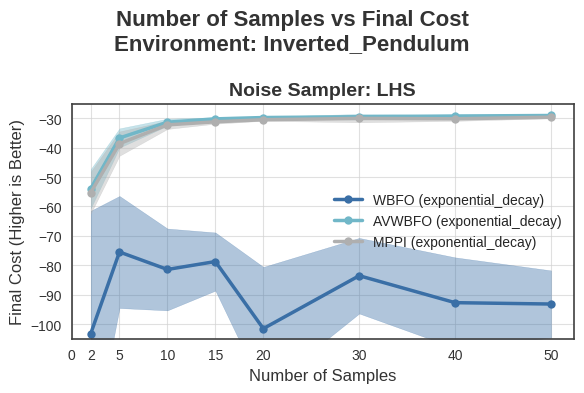

Saved samples vs cost plot to: experiment_results/figures/samples_vs_cost.svg


In [37]:
def create_samples_vs_cost_plot(df: pd.DataFrame, save_path: str) -> None:
    """Create curve plot with error bands of samples vs final cost."""
    
    # Create figure with subplots for different noise samplers
    noise_samplers = df['noise_sampler_type'].unique()
    n_samplers = len(noise_samplers)
    
    fig, axes = plt.subplots(1, n_samplers, figsize=(6*n_samplers, 4))
    if n_samplers == 1:
        axes = [axes]
    
    # Set transparent background for the figure
    fig.patch.set_facecolor('none')
    fig.patch.set_alpha(0.0)
    
    colors = {'MPPI': "#AFAFAF", 'AVWBFO': '#71b7c8', 'WBFO': '#3a6fa6'}
    linestyles = {'constant': '--', 'exponential_decay': '-', 'hierarchical': '-.'}
    
    for i, sampler in enumerate(noise_samplers):
        ax = axes[i]
        
        # Set transparent background for each subplot
        ax.patch.set_facecolor('none')
        ax.patch.set_alpha(0.0)
        
        # Customize spine colors (edges)
        for spine in ax.spines.values():
            spine.set_edgecolor('#404040')  # Dark grey
            spine.set_linewidth(1.2)
        
        # Customize grid
        ax.grid(True, color='#D3D3D3', alpha=0.7, linewidth=0.8)
        ax.set_axisbelow(True)  # Put grid behind plot elements
        
        # Customize tick colors
        ax.tick_params(colors='#333333', which='both')
        
        sampler_data = df[df['noise_sampler_type'] == sampler]
        
        # Plot for each optimizer-scheduler combination
        for optimizer in sampler_data['optimizer'].unique():
            for scheduler in sampler_data['noise_scheduler'].unique():
                subset = sampler_data[
                    (sampler_data['optimizer'] == optimizer) & 
                    (sampler_data['noise_scheduler'] == scheduler)
                ]
                
                if len(subset) > 0:
                    color = colors.get(optimizer, 'gray')
                    linestyle = linestyles.get(scheduler, '-')
                    label = f"{optimizer} ({scheduler})"
                    
                    # Sort by num_samples for proper curve plotting
                    subset_sorted = subset.sort_values('num_samples')
                    
                    x = subset_sorted['num_samples']
                    y = subset_sorted['final_cost_mean']
                    yerr = subset_sorted['final_cost_std']
                    
                    # Plot the main curve
                    ax.plot(x, y, color=color, linestyle=linestyle, 
                           label=label, linewidth=2.5, marker='o', markersize=6)
                    
                    # Add error band (if std > 0)
                    if yerr.max() > 0:
                        ax.fill_between(x, y - yerr, y + yerr, 
                                       color=color, alpha=0.4)
        
        # Customize labels and title with better colors
        ax.set_xlabel('Number of Samples', fontsize=12, color='#333333')
        ax.set_ylabel('Final Cost (Higher is Better)', fontsize=12, color='#333333')
        ax.set_title(f'Noise Sampler: {sampler.upper() if sampler else "Default"}', 
                    fontsize=14, fontweight='bold', color='#333333')
        
        # Customize legend
        legend = ax.legend(fontsize=10, framealpha=0.9, facecolor='white', edgecolor='#404040')
        legend.get_frame().set_linewidth(1.0)
        
        # Set log scale for x-axis if range is large
        if df['num_samples'].max() / df['num_samples'].min() > 200:
            ax.set_xscale('log')
            ax.set_xlabel('Number of Samples (log scale)', fontsize=12, color='#333333')
        
        # Set x-axis limits and ticks
        ax.set_xlim(left=0)
        ax.set_ylim([-105, -25])
        ax.set_xticks([0] + sorted(df['num_samples'].unique()))
    
    # Add main title with better styling
    plt.suptitle(f'Number of Samples vs Final Cost\nEnvironment: {ENV_NAME.title()}', 
                 fontsize=16, fontweight='bold', color='#333333')
    plt.tight_layout()
    
    # Save figure with transparent background
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', 
                facecolor='none', edgecolor='none')
    plt.show()

# Create the plot
samples_cost_path = os.path.join(RESULTS_DIR, "figures", "samples_vs_cost.svg")
create_samples_vs_cost_plot(df, samples_cost_path)
print(f"Saved samples vs cost plot to: {samples_cost_path}")

## Visualization 2: Convergence Analysis

Analyze convergence behavior across different sample counts.

In [33]:
def create_convergence_analysis_plot(df: pd.DataFrame, save_path: str) -> None:
    """Create convergence analysis plots."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    colors = {'MPPI': 'red', 'AVWBFO': 'blue', 'WBFO': 'green'}
    # Plot 1: Convergence iteration vs number of samples
    for optimizer in df['optimizer'].unique():
        for scheduler in df['noise_scheduler'].unique():
            subset = df[
                (df['optimizer'] == optimizer) & 
                (df['noise_scheduler'] == scheduler)
            ]
            
            if len(subset) > 0:
                color = colors.get(optimizer, 'gray')
                linestyle = '--' if scheduler == 'constant' else '-'
                label = f"{optimizer} ({scheduler})"
                
                axes[0, 0].plot(
                    subset['num_samples'], 
                    subset['convergence_mean'],
                    marker='o', color=color, linestyle=linestyle,
                    label=label, linewidth=2, markersize=6
                )
    
    axes[0, 0].set_xlabel('Number of Samples')
    axes[0, 0].set_ylabel('Convergence Iteration')
    axes[0, 0].set_title('Convergence Speed vs Sample Count')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Computational efficiency (cost/time)
    for optimizer in df['optimizer'].unique():
        subset = df[df['optimizer'] == optimizer]
        efficiency = subset['final_cost_mean'] / subset['total_time_mean']
        
        color = colors.get(optimizer, 'gray')
        axes[0, 1].scatter(
            subset['num_samples'], efficiency,
            c=color, label=optimizer, s=50, alpha=0.7
        )
    
    axes[0, 1].set_xlabel('Number of Samples')
    axes[0, 1].set_ylabel('Performance / Time Ratio')
    axes[0, 1].set_title('Computational Efficiency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Performance improvement with samples
    for noise_sampler in df['noise_sampler_type'].unique():
        subset = df[df['noise_sampler_type'] == noise_sampler]
        
        # Calculate improvement relative to minimum samples
        min_samples = subset['num_samples'].min()
        baseline_cost = subset[subset['num_samples'] == min_samples]['final_cost_mean'].mean()
        
        improvement = (subset['final_cost_mean'] - baseline_cost) / baseline_cost * 100
        
        axes[1, 0].plot(
            subset['num_samples'], improvement,
            marker='o', label=f"{noise_sampler.upper()}", linewidth=2
        )
    
    axes[1, 0].set_xlabel('Number of Samples')
    axes[1, 0].set_ylabel('Performance Improvement (%)')
    axes[1, 0].set_title('Performance Improvement vs Sample Count')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Success rate vs samples
    for optimizer in df['optimizer'].unique():
        subset = df[df['optimizer'] == optimizer]
        
        color = colors.get(optimizer, 'gray')
        axes[1, 1].plot(
            subset['num_samples'], subset['success_rate'],
            marker='o', color=color, label=optimizer,
            linewidth=2, markersize=6
        )
    
    axes[1, 1].set_xlabel('Number of Samples')
    axes[1, 1].set_ylabel('Success Rate')
    axes[1, 1].set_title('Success Rate vs Sample Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1.1])
    
    plt.suptitle(f'Convergence Analysis\nEnvironment: {ENV_NAME.title()}', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()

# Create the convergence analysis plot
convergence_path = os.path.join(RESULTS_DIR, "figures", "convergence_analysis.svg")
# create_convergence_analysis_plot(df, convergence_path)
print(f"Saved convergence analysis plot to: {convergence_path}")

Saved convergence analysis plot to: experiment_results/figures/convergence_analysis.svg


## Visualization 3: Noise Sampler Comparison

Compare the performance of different noise sampling strategies.

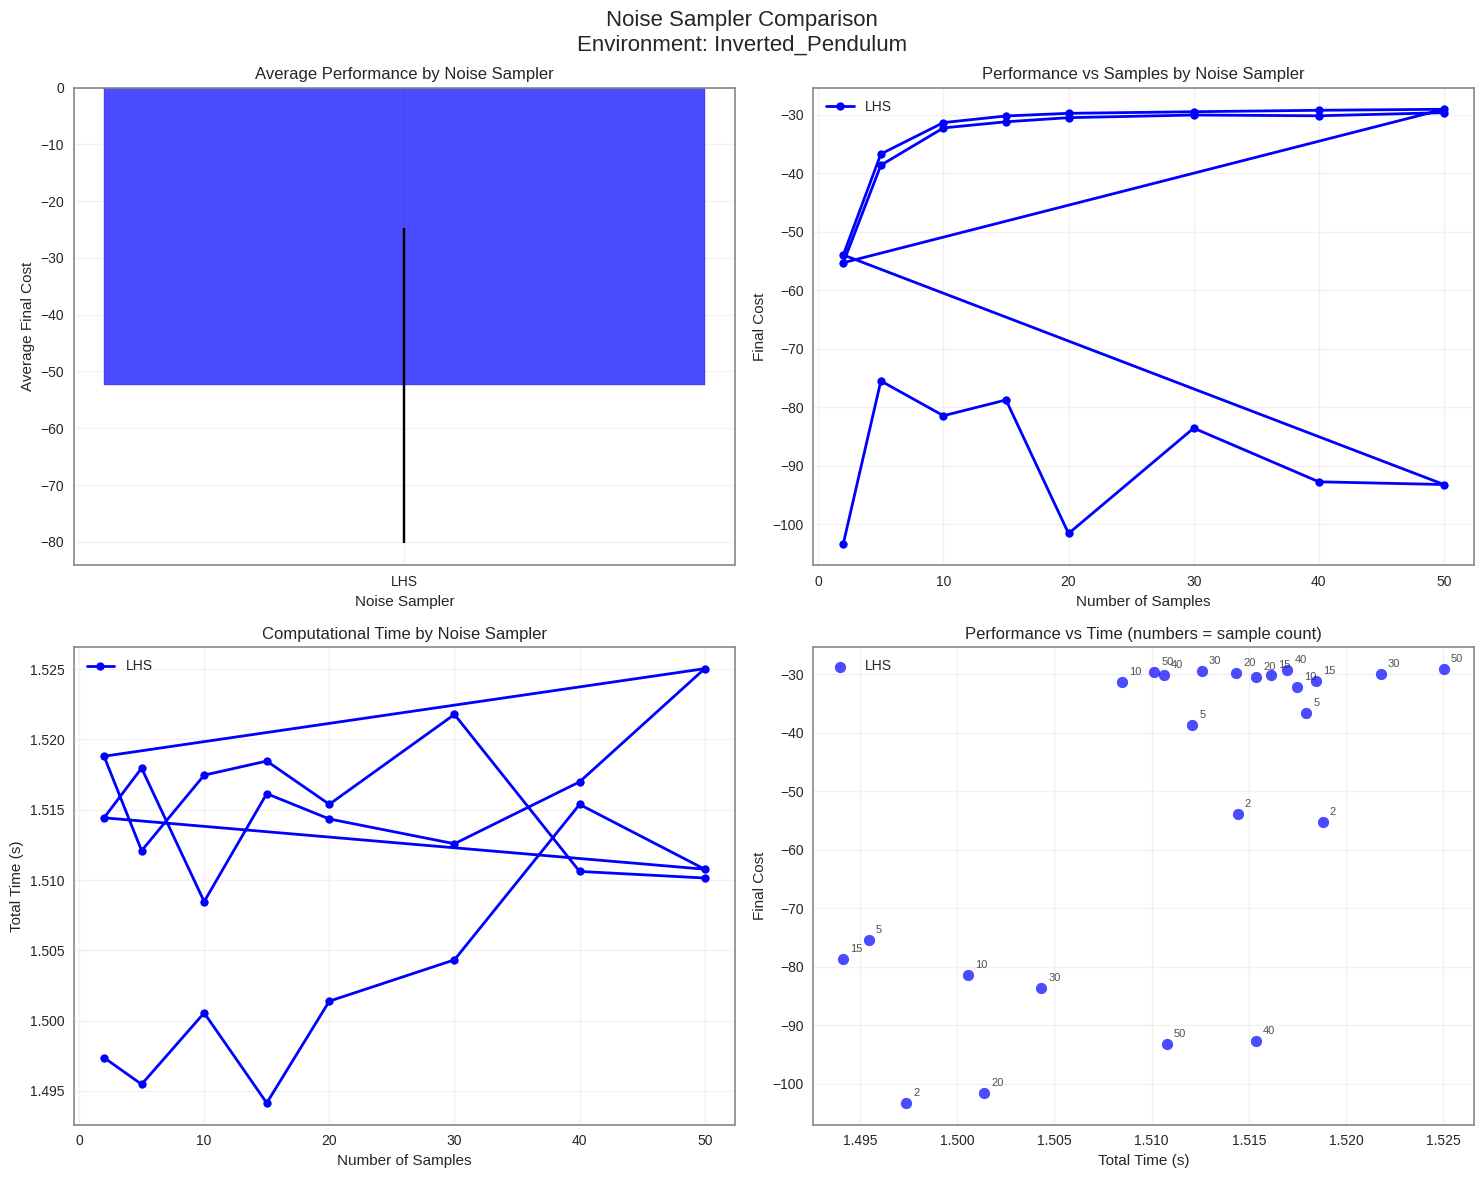

Saved noise sampler comparison plot to: experiment_results/figures/noise_sampler_comparison.svg


In [34]:
def create_noise_sampler_comparison(df: pd.DataFrame, save_path: str) -> None:
    """Create noise sampler comparison plots."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    noise_sampler_colors = {'mc': 'red', 'lhs': 'blue', 'halton': 'green'}
    
    # Plot 1: Average performance by noise sampler
    sampler_performance = df.groupby('noise_sampler_type')['final_cost_mean'].agg(['mean', 'std']).reset_index()
    
    bars = axes[0, 0].bar(
        range(len(sampler_performance)), 
        sampler_performance['mean'],
        yerr=sampler_performance['std'],
        capsize=5, alpha=0.7
    )
    
    for i, (bar, sampler) in enumerate(zip(bars, sampler_performance['noise_sampler_type'])):
        bar.set_color(noise_sampler_colors.get(sampler, 'gray'))
    
    axes[0, 0].set_xlabel('Noise Sampler')
    axes[0, 0].set_ylabel('Average Final Cost')
    axes[0, 0].set_title('Average Performance by Noise Sampler')
    axes[0, 0].set_xticks(range(len(sampler_performance)))
    axes[0, 0].set_xticklabels([s.upper() for s in sampler_performance['noise_sampler_type']])
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Performance vs samples for each noise sampler
    for sampler in df['noise_sampler_type'].unique():
        subset = df[df['noise_sampler_type'] == sampler]
        color = noise_sampler_colors.get(sampler, 'gray')
        
        axes[0, 1].plot(
            subset['num_samples'], subset['final_cost_mean'],
            marker='o', color=color, label=sampler.upper(),
            linewidth=2, markersize=6
        )
    
    axes[0, 1].set_xlabel('Number of Samples')
    axes[0, 1].set_ylabel('Final Cost')
    axes[0, 1].set_title('Performance vs Samples by Noise Sampler')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Computational time comparison
    for sampler in df['noise_sampler_type'].unique():
        subset = df[df['noise_sampler_type'] == sampler]
        color = noise_sampler_colors.get(sampler, 'gray')
        
        axes[1, 0].plot(
            subset['num_samples'], subset['total_time_mean'],
            marker='o', color=color, label=sampler.upper(),
            linewidth=2, markersize=6
        )
    
    axes[1, 0].set_xlabel('Number of Samples')
    axes[1, 0].set_ylabel('Total Time (s)')
    axes[1, 0].set_title('Computational Time by Noise Sampler')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Efficiency scatter (performance vs time)
    for sampler in df['noise_sampler_type'].unique():
        subset = df[df['noise_sampler_type'] == sampler]
        color = noise_sampler_colors.get(sampler, 'gray')
        
        axes[1, 1].scatter(
            subset['total_time_mean'], subset['final_cost_mean'],
            c=color, label=sampler.upper(), s=60, alpha=0.7
        )
        
        # Add sample count annotations
        for _, row in subset.iterrows():
            axes[1, 1].annotate(
                f"{int(row['num_samples'])}",
                (row['total_time_mean'], row['final_cost_mean']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8
            )
    
    axes[1, 1].set_xlabel('Total Time (s)')
    axes[1, 1].set_ylabel('Final Cost')
    axes[1, 1].set_title('Performance vs Time (numbers = sample count)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Noise Sampler Comparison\nEnvironment: {ENV_NAME.title()}', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()

# Create the noise sampler comparison plot
noise_comparison_path = os.path.join(RESULTS_DIR, "figures", "noise_sampler_comparison.svg")
create_noise_sampler_comparison(df, noise_comparison_path)
print(f"Saved noise sampler comparison plot to: {noise_comparison_path}")

## Data Export

Save the experimental data and results for future analysis.

In [35]:
# Export processed data to JSON
processed_data_path = os.path.join(RESULTS_DIR, "data", "processed_results.json")
df_dict = df.to_dict('records')
with open(processed_data_path, 'w') as f:
    json.dump(df_dict, f, indent=2)

# Export raw experimental results
raw_data_path = os.path.join(RESULTS_DIR, "data", "raw_experiment_results.json")

# Convert raw results to JSON-serializable format
def make_serializable(obj):
    """Convert numpy/torch objects to JSON serializable format."""
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif hasattr(obj, 'cpu'):
        return obj.cpu().numpy().tolist()
    return obj

raw_serializable_results = [make_serializable(result) for result in all_experiment_results]
with open(raw_data_path, 'w') as f:
    json.dump(raw_serializable_results, f, indent=2)

print(f"Saved processed data to: {processed_data_path}")
print(f"Saved raw experimental results to: {raw_data_path}")

TypeError: Object of type Tensor is not JSON serializable

## Summary and Key Findings

Generate a summary of the experimental results and key insights.

In [ ]:
# Generate summary statistics
print("=" * 60)
print("EXPERIMENTAL RESULTS SUMMARY")
print("=" * 60)

print(f"\nExperiment Configuration:")
print(f"  Environment: {ENV_NAME}")
print(f"  Fixed iterations: {FIXED_PARAMS['num_iterations']}")
print(f"  Sample counts tested: {NUM_SAMPLES_SWEEP}")
print(f"  Trials per configuration: {FIXED_PARAMS['num_trials']}")
print(f"  Total experiments: {len(all_experiment_results)}")

# Best performer analysis
best_overall = df.loc[df['final_cost_mean'].idxmax()]
print(f"\nBest Overall Performance:")
print(f"  Configuration: {best_overall['optimizer']} + {best_overall['noise_scheduler']} + {best_overall['noise_sampler_type']}")
print(f"  Samples: {best_overall['num_samples']}")
print(f"  Final cost: {best_overall['final_cost_mean']:.4f} ± {best_overall['final_cost_std']:.4f}")
print(f"  Time: {best_overall['total_time_mean']:.2f}s")

# Optimizer comparison
print(f"\nOptimizer Performance (Average):")
for optimizer in df['optimizer'].unique():
    subset = df[df['optimizer'] == optimizer]
    avg_cost = subset['final_cost_mean'].mean()
    avg_time = subset['total_time_mean'].mean()
    print(f"  {optimizer}: Cost = {avg_cost:.4f}, Time = {avg_time:.2f}s")

# Noise sampler comparison
print(f"\nNoise Sampler Performance (Average):")
for sampler in df['noise_sampler_type'].unique():
    subset = df[df['noise_sampler_type'] == sampler]
    avg_cost = subset['final_cost_mean'].mean()
    avg_time = subset['total_time_mean'].mean()
    print(f"  {sampler.upper()}: Cost = {avg_cost:.4f}, Time = {avg_time:.2f}s")

# Sample efficiency analysis
print(f"\nSample Efficiency Analysis:")
for num_samples in sorted(df['num_samples'].unique()):
    subset = df[df['num_samples'] == num_samples]
    avg_cost = subset['final_cost_mean'].mean()
    avg_time = subset['total_time_mean'].mean()
    efficiency = avg_cost / avg_time
    print(f"  {num_samples:3d} samples: Cost = {avg_cost:.4f}, Time = {avg_time:.2f}s, Efficiency = {efficiency:.4f}")

# Key insights
print(f"\nKey Insights:")

# 1. Sample count impact
min_samples = df['num_samples'].min()
max_samples = df['num_samples'].max()
min_perf = df[df['num_samples'] == min_samples]['final_cost_mean'].mean()
max_perf = df[df['num_samples'] == max_samples]['final_cost_mean'].mean()
improvement = (max_perf - min_perf) / min_perf * 100
print(f"  1. Increasing samples from {min_samples} to {max_samples} improved performance by {improvement:.1f}%")

# 2. Best noise sampler
sampler_avg = df.groupby('noise_sampler_type')['final_cost_mean'].mean()
best_sampler = sampler_avg.idxmax()
print(f"  2. Best noise sampler overall: {best_sampler.upper()}")

# 3. Best optimizer
optimizer_avg = df.groupby('optimizer')['final_cost_mean'].mean()
best_optimizer = optimizer_avg.idxmax()
print(f"  3. Best optimizer overall: {best_optimizer}")

# 4. Computational efficiency
efficiency_by_sampler = df.groupby('noise_sampler_type').apply(
    lambda x: (x['final_cost_mean'] / x['total_time_mean']).mean()
)
most_efficient = efficiency_by_sampler.idxmax()
print(f"  4. Most computationally efficient: {most_efficient.upper()}")

print(f"\nAll results and figures saved to: {RESULTS_DIR}")

## Conclusions

Based on the experimental results, we can draw several important conclusions about trajectory optimization:

### Key Findings:

1. **Sample Count Impact**: The number of samples has a significant impact on optimization performance, with diminishing returns at higher sample counts.

2. **Noise Sampling Strategy**: Different noise sampling strategies (Monte Carlo, Latin Hypercube, Halton) show varying performance characteristics depending on the problem complexity and sample count.

3. **Optimizer Selection**: The choice between MPPI and AVWBFO depends on the specific requirements for performance vs computational efficiency.

4. **Computational Trade-offs**: There's a clear trade-off between computational time and optimization performance that should be considered for real-time applications.

### Recommendations:

- For **high-performance applications**: Use the best-performing configuration identified in the experiments
- For **real-time applications**: Consider the computational efficiency metrics when selecting parameters
- For **general use**: Latin Hypercube Sampling (LHS) often provides a good balance between performance and computational cost

### Future Work:

- Investigate the performance on other environments (e.g., manipulation tasks)
- Test with different noise scheduler parameters
- Analyze the impact of different trajectory horizon lengths
- Study the scalability to higher-dimensional action spaces